# Linear Regression with Statsmodels for Movie Revenue

- 05/10/22

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Today we will be working with JUST the data data from the TMDB API for years 2000-2021. 
    - We will prepare the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We will fit a statsmodels linear regression.
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.



- Next class we will continue this activity.
    - We will better check all 4 assumptions.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations.

### Concepts Demonstrated

- [ ] Using `glob` for loading in all final files. 
- [ ] Statsmodels OLS
- [ ] QQ-Plot
- [ ] Residual Plot

# Loading the Data

In [20]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

In [21]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [22]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data/'
file_list = sorted(os.listdir(FOLDER))
file_list

['.DS_Store',
 '.ipynb_checkpoints',
 '2010-2021',
 'combined_tmdb_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2002.json',
 'tmdb_api_results_2003.json',
 'tmdb_api_results_2004.json',
 'tmdb_api_results_2005.json',
 'tmdb_api_results_2006.json',
 'tmdb_api_results_2007.json',
 'tmdb_api_results_2008.json',
 'tmdb_api_results_2009.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_a

In [23]:
# ## Try loading in the first .csv.gz file from the list
# pd.read_csv(file_list[4])

> Why isn't it working?

In [24]:
## let's check the filepath 
FOLDER+file_list[4]

'Data/final_tmdb_data_2000.csv.gz'

In [25]:
## add the folder plus filename
pd.read_csv(FOLDER+file_list[4])

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.491,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,1.974,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",1.341,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",22.411,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': None, 'name': 'Block...","[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...",2000-09-29,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1868.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,tt6174238,0.0,NaN,"{'id': 404302, 'name': 'Cold War Collection', ...",0.0,"[{'id': 80, 'name': 'Crime'}]",NaN,223878.0,en,Cold War,"Since the death of his wife three years ago, K...",0.913,/4p58ILmqsfPGS9iRCX3riekJt8e.jpg,[],"[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",2000-06-17,0.0,0.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Cold War,0.0,2.0,2.0,NaN
1194,tt7029820,0.0,NaN,NaN,0.0,[],NaN,604889.0,en,Scream For Christmas,A Christmas party is interrupted by a violent ...,0.600,NaN,[],[],NaN,0.0,80.0,[],Released,NaN,Scream For Christmas,0.0,0.0,0.0,NaN
1195,tt7197642,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,872676.0,en,"Goodbye, Merry-Go-Round",Maryland comedy,0.600,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2000-12-12,0.0,90.0,[],Released,NaN,"Goodbye, Merry-Go-Round",0.0,0.0,0.0,NaN
1196,tt7631368,0.0,/sF0gUHE0YzZNXYugTB2LFxJIppf.jpg,NaN,10000000.0,"[{'id': 27, 'name': 'Horror'}]",NaN,97186.0,fr,"I, Vampire",A sensual trilogy of vampire stories from Wiza...,0.987,/cl47LE7zYELjTzH7gfyvzBrCG5W.jpg,[],[],2000-10-17,0.0,85.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,"I, Vampire",0.0,6.4,4.0,NR


- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [26]:
import glob
## Make a filepath query
q = FOLDER+"final*.csv.gz"
print(q)
file_list = sorted(glob.glob(q))
file_list


Data/final*.csv.gz


['Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

In [27]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"/**/final*.csv.gz"
print(q)
file_list = sorted(glob.glob(q,recursive=True))
file_list


Data//**/final*.csv.gz


['Data/2010-2021/final_tmdb_data_2010.csv.gz',
 'Data/2010-2021/final_tmdb_data_2011.csv.gz',
 'Data/2010-2021/final_tmdb_data_2012.csv.gz',
 'Data/2010-2021/final_tmdb_data_2013.csv.gz',
 'Data/2010-2021/final_tmdb_data_2014.csv.gz',
 'Data/2010-2021/final_tmdb_data_2015.csv.gz',
 'Data/2010-2021/final_tmdb_data_2016.csv.gz',
 'Data/2010-2021/final_tmdb_data_2017.csv.gz',
 'Data/2010-2021/final_tmdb_data_2018.csv.gz',
 'Data/2010-2021/final_tmdb_data_2019.csv.gz',
 'Data/2010-2021/final_tmdb_data_2020.csv.gz',
 'Data/2010-2021/final_tmdb_data_2021.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

> But where are the rest of the years?

- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [28]:
# # ## use a list comprehension to load in all files into 1 dataframe
# df_list = []

# for file in file_list:
#     df = pd.read_csv(file)
#     df_list.append(df)

- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [29]:
# df_list[0]

In [30]:
## use a list comprehension to load in all files into 1 dataframe
# ## use a list comprehension to load in all files into 1 dataframe
df_list = []

for file in file_list:
    df = pd.read_csv(file, lineterminator="\n")
    df_list.append(df)
    
df = pd.concat(df_list)
df.reset_index(inplace=True,drop=True)
# df

In [31]:
df = pd.concat([pd.read_csv(file, lineterminator="\n") for file in file_list])
df.reset_index(inplace=True, drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60147,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60148,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60149,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60150,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


### Filtering

- Make sure to only keep:
    0. Movies with actual imdb_id's (!="0")
    1. Status=Released.
    2. Budget >0
    3. Revenue >0

In [32]:
# remove ids that are 0  and then reset index
df = df[df['imdb_id'] != '0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60147,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60148,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60149,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60150,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


### New 06/12/22

<AxesSubplot:>

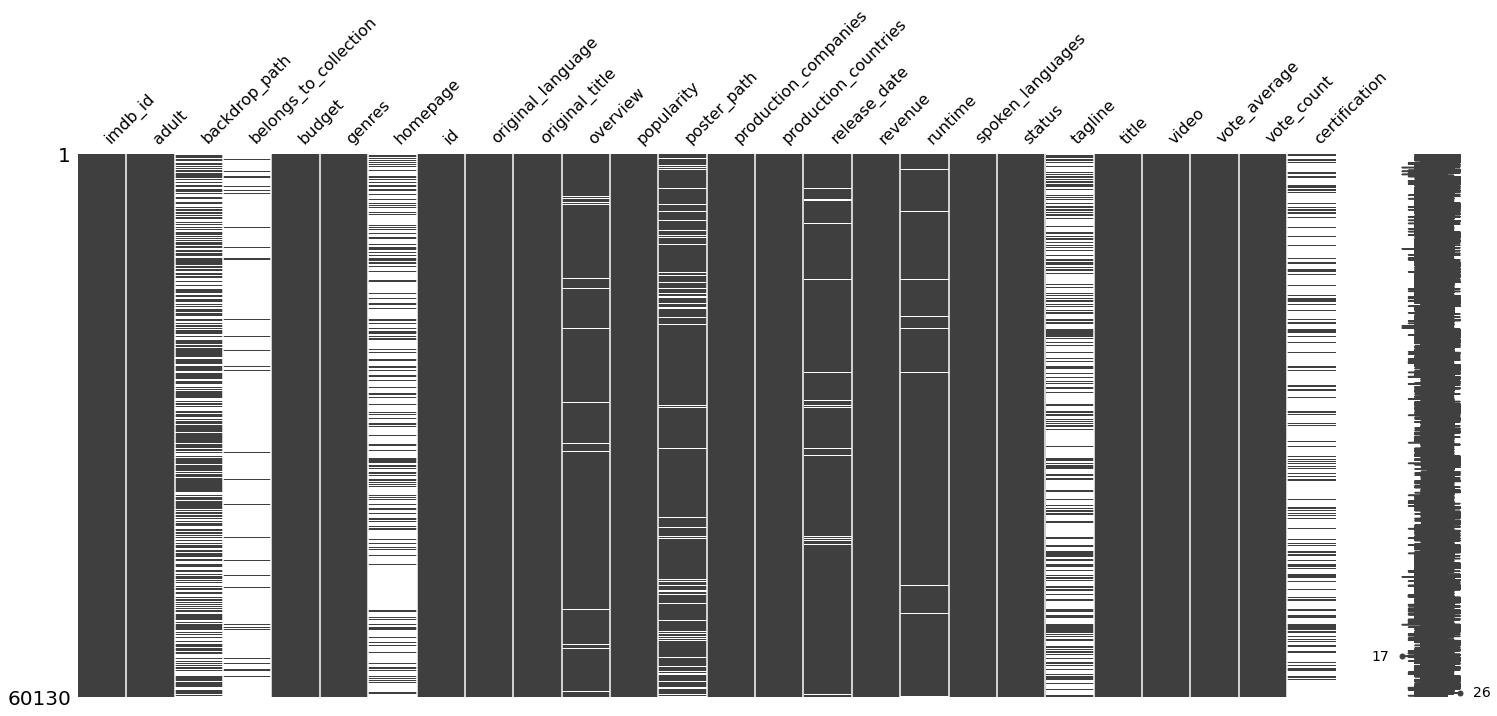

In [33]:
import missingno
missingno.matrix(df)

In [34]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [35]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60147,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60148,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],NaN,Tattoo,0.0,5.0,1.0,NaN
60149,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60150,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [42]:
(df['revenue'] ==0).sum()/len(df)

0.8762500623991214

In [43]:
df.loc[(df['budget'] >0 ) & (df['revenue']>0)]

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,5.924617e+08,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
7,tt0411951,0.0,/rbB7g8YBFMLKtmwB8QEvVlKh5Yh.jpg,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,42194.0,en,Tekken,"In the year of 2039, after World Wars destroy ...",70.694,/1xO2LirDZstkqZic1FwfK6GJIHH.jpg,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-20,9.670000e+05,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Survival is no game,Tekken,0.0,5.4,553.0,R
10,tt0427152,0.0,/2bNvoxVPyfiuNh7vmRvwePY5Paf.jpg,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.dinnerforschmucks.com/,38778.0,en,Dinner for Schmucks,Rising executive Tim Conrad works for a boss w...,21.747,/djwkUFhkM81gIsI9ZZ7I6ajZAKY.jpg,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-30,8.638786e+07,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Takes One To Know One.,Dinner for Schmucks,0.0,5.6,1452.0,PG-13
11,tt0429493,0.0,/hy1QuQa0sCJAmVAVySYZpMk1okk.jpg,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",https://www.20thcenturystudios.com/movies/the-...,34544.0,en,The A-Team,A group of Iraq War veterans goes on the run f...,56.494,/bkAWEx5g5tvRPjtDQyvIZ7LRxQm.jpg,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-09,1.772388e+08,117.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",There Is No Plan B,The A-Team,0.0,6.4,3877.0,PG-13
12,tt0435761,0.0,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193.0,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",93.983,/AbbXspMOwdvwWZgVN0nabZq03Ec.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-16,1.066970e+09,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No toy gets left behind.,Toy Story 3,0.0,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59881,tt1532382,0.0,/mLajVFwUGjmCvjLP53iPrTJ5Yk5.jpg,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,37656.0,ru,На игре,After a stunning victory at a cyber sport tour...,4.838,/9RSVyIwttjIMcCOgpszmkXka5wt.jpg,[],"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2009-11-26,3.704408e+06,97.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",NaN,Hooked on the Game,0.0,6.3,42.0,NaN
59909,tt1542960,0.0,/tPgyX4Y03VHywSwMrMsQzF7Syc0.jpg,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",https://en.wikipedia.org/wiki/The_Figurine,381961.0,en,Araromire,"Two buddies and a girl, down on their luck, ha...",1.937,/uwFNP7jSpCy2sKXsj2dJwJi5r1l.jpg,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...","[{'iso_3166_1': 'NG', 'name': 'Nigeria'}]",2009-10-02,2.000000e+05,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No one told them about the next seven years...,The Figurine (Araromire),0.0,4.2,11.0,NaN
59945,tt1560950,0

In [44]:
# filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,5.924617e+08,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
7,tt0411951,0.0,/rbB7g8YBFMLKtmwB8QEvVlKh5Yh.jpg,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,42194.0,en,Tekken,"In the year of 2039, after World Wars destroy ...",70.694,/1xO2LirDZstkqZic1FwfK6GJIHH.jpg,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-20,9.670000e+05,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Survival is no game,Tekken,0.0,5.4,553.0,R
10,tt0427152,0.0,/2bNvoxVPyfiuNh7vmRvwePY5Paf.jpg,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.dinnerforschmucks.com/,38778.0,en,Dinner for Schmucks,Rising executive Tim Conrad works for a boss w...,21.747,/djwkUFhkM81gIsI9ZZ7I6ajZAKY.jpg,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-30,8.638786e+07,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Takes One To Know One.,Dinner for Schmucks,0.0,5.6,1452.0,PG-13
11,tt0429493,0.0,/hy1QuQa0sCJAmVAVySYZpMk1okk.jpg,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",https://www.20thcenturystudios.com/movies/the-...,34544.0,en,The A-Team,A group of Iraq War veterans goes on the run f...,56.494,/bkAWEx5g5tvRPjtDQyvIZ7LRxQm.jpg,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-09,1.772388e+08,117.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",There Is No Plan B,The A-Team,0.0,6.4,3877.0,PG-13
12,tt0435761,0.0,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193.0,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",93.983,/AbbXspMOwdvwWZgVN0nabZq03Ec.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-16,1.066970e+09,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No toy gets left behind.,Toy Story 3,0.0,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59881,tt1532382,0.0,/mLajVFwUGjmCvjLP53iPrTJ5Yk5.jpg,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,37656.0,ru,На игре,After a stunning victory at a cyber sport tour...,4.838,/9RSVyIwttjIMcCOgpszmkXka5wt.jpg,[],"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2009-11-26,3.704408e+06,97.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",NaN,Hooked on the Game,0.0,6.3,42.0,NaN
59909,tt1542960,0.0,/tPgyX4Y03VHywSwMrMsQzF7Syc0.jpg,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",https://en.wikipedia.org/wiki/The_Figurine,381961.0,en,Araromire,"Two buddies and a girl, down on their luck, ha...",1.937,/uwFNP7jSpCy2sKXsj2dJwJi5r1l.jpg,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...","[{'iso_3166_1': 'NG', 'name': 'Nigeria'}]",2009-10-02,2.000000e+05,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No one told them about the next seven years...,The Figurine (Araromire),0.0,4.2,11.0,NaN
59945,tt1560950,0

In [ ]:
df.describ

In [47]:
df.sort_values('revenue', ascending=False)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
57886,tt0499549,0.0,/jlQJDD0L5ZojjlS0KYnApdO0n19.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.avatar.com/movies/avatar,19995.0,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",388.074,/jRXYjXNq0Cs2TcJjLkki24MLp7u.jpg,"[{'id': 444, 'logo_path': '/42UPdZl6B2cFXgNUAS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2.847246e+09,162.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Enter the world of Pandora.,Avatar,0.0,7.5,25327.0,PG-13
33750,tt4154796,0.0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534.0,en,Avengers: Endgame,After the devastating events of Avengers: Infi...,257.309,/or06FN3Dka5tukK1e9sl16pB3iy.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-04-24,2.797801e+09,181.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Part of the journey is the end.,Avengers: Endgame,0.0,8.3,20953.0,PG-13
16170,tt2488496,0.0,/8BTsTfln4jlQrLXUBquXJ0ASQy9.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607.0,en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,79.306,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,"[{'id': 1, 'logo_path': '/o86DbpburjxrqAzEDhXZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,2.068224e+09,136.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Every generation has a story.,Star Wars: The Force Awakens,0.0,7.3,16958.0,PG-13
28117,tt4154756,0.0,/lmZFxXgJE3vgrciwuDib0N8CfQo.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",300000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://www.marvel.com/movies/avengers-infinit...,299536.0,en,Avengers: Infinity War,As the Avengers and their allies have continue...,381.844,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2018-04-25,2.046240e+09,149.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",An entire universe. Once and for all.,Avengers: Infinity War,0.0,8.3,24509.0,PG-13
40870,tt10872600,0.0,/iQFcwSGbZXMkeyKrxbPnwnRo5fl.jpg,"{'id': 531241, 'name': 'Spider-Man (Avengers) ...",200000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.spidermannowayhome.movie,634649.0,en,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5086.675,/1g0dhYtq4irTY1GPXvft6k4YLjm.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2021-12-15,1.892000e+09,148.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",The Multiverse unleashed.,Spider-Man: No Way Home,0.0,8.1,12527.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44406,tt0196106,0.0,/r4vnelohQBrUKhl181s4PjdRMTz.jpg,"{'id': 368982, 'name': 'MVP', 'poster_path': '...",4.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",NaN,32834.0,en,MVP: Most Valuable Primate,Jack is a three-year-old chimpanzee who has be...,6.206,/pRCciMvFOABm41eat8EKYa0BYIL.jpg,"[{'id': 31015, 'logo_path': None, 'name': 'Key...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-08-11,1.000000e+00,85.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Jack skates a little faster... Shoots a little...,MVP: Most Valuable Primate,0.0,4.9,65.0,PG
33022,tt10847812,0.0,NaN,NaN,95.0,[],https://www.thejohnnyh

In [ ]:
## saving the combined csv to disk


# Preprocessing

In [ ]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','status','tagline','id','homepage',
                 'production_countries','video','production_companies','spoken_languages',
            'original_language']

## drop columns
df = df.drop(columns=drop_cols)
df

## Feature Engineering


- belongs to collection: convert to boolean
- Genres: get just name and manually OHE
- Cleaning Categories in Certification
- Converting release date to year, month, and day.

### belongs to collection

In [ ]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

In [ ]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

### genre

In [ ]:
df['genres']

In [ ]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [ ]:
## Use our function and exploding the new column
genre_split = df['genres'].apply(get_genre_name)
genre_split

In [ ]:
unique_genres = genre_split.explode().dropna().unique()
unique_genres

In [ ]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre)
df

In [ ]:
## Drop original genre cols
df = df.drop(columns='genres')

### certification

In [ ]:
## Checking Certification values
df['certification'].value_counts(dropna=False)

In [ ]:
# df.select_dtypes('object')

In [ ]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()
df['certification'].value_counts(dropna=False)

In [ ]:
## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':np.nan}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

### Converting year to sep features

In [ ]:
df['release_date']
df['release_date'].str.split('-', expand=True)

In [ ]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

df

In [ ]:
## drop original feature
df = df.drop(columns=['release_date'])

## Train Test Split

In [ ]:
df.info()

In [ ]:
## Make x and y variables
drop_for_model = ['title','imdb_id']

y = df['revenue'].copy()
X = df.drop(columns=['revenue',*drop_for_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

In [ ]:
X_train.isna().sum()

In [ ]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

In [ ]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

In [ ]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

In [ ]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [ ]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols),
                                       ('passthrough',already_ohe_cols))# remainder='passthrough')
preprocessor

In [ ]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-1']

In [ ]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-1'][-1].get_feature_names_out(cat_cols)

## Create the empty list
final_features = [*cat_features,*num_cols,*already_ohe_cols]
len(final_features)

In [ ]:
## checking shape matches len final features
preprocessor.transform(X_train).shape

In [ ]:
## make X_train_tf 
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()

In [ ]:
## make X_test_tf 

X_test_tf = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)
X_test_tf.head()

### Adding a Constant for Statsmodels

In [ ]:
##import statsmodels correctly
import statsmodels.api  as sm
sm


> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [ ]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False,has_constant='add')

In [ ]:
display(X_train_df.head(2), X_test_df.head(2))

# Modeling

## Statsmodels OLS

In [ ]:
## instantiate an OLS model WITH the training data.
model= sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

In [ ]:
## Get train data performance from skearn to confirm matches OLS


## Get test data performance


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ-Plot for Checking for Normality

In [ ]:
## Create a Q-QPlot

# first calculate residuals 


## then use sm's qqplot


### Residual Plot for Checking Homoscedasticity

In [ ]:
## Plot scatterplot with y_hat_test vs resids


### Putting it all together

In [ ]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)



> Next class: iterating on our model & interpreting coefficients